# Experimental feature: Calculating lexical diversity of limericks to rank and select
Rami Ariss, March 30th 2022

NLTK (Natural Language Toolkit, https://www.nltk.org/) is a useful python package to do various text-based statistical and metric calculations.

For example, we can use NLTK to define sets of text to calculate the lexical diversity over a limerick, and rank a set of generated limericks based on the lexical diversity.

NLTK can enable metric calculations such as:
- lexical diversity: % words repeatedly used in given text
- collocations: words used together often
- word counts

Resources:
- Parts of Speech Tags: https://www.ibm.com/docs/en/watson-explorer/10.0.0?topic=analytics-part-speech-tag-sets
- NLTK examples: https://www.nltk.org/book/ch01.html
- NLTK Pre-Process notebook example: https://colab.research.google.com/github/gal-a/blog/blob/master/docs/notebooks/nlp/nltk_preprocess.ipynb#scrollTo=0JzUMH4jdXm7

# Notebook Preparation

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 
nltk.download('treebank')

import pandas as pd
import matplotlib.pyplot as plt
import io
import unicodedata
import numpy as np
import re
import string
import json
import glob
import os

from scipy import stats
import seaborn as sns

%matplotlib inline

# Lexical Diversity
Calculate type-token-ration (TTR) lexical diversity for poems as the ratio of unique tokens $V$ to all tokens $N$ in a poem:

$TTR=\frac{V}{N}$

In [ ]:
def calculate_lexical_diversity(text):
  """Given a tokenized text, calculate its lexical diversity.

  :param text: list, tokenized text
  :return: float, lexical diversity
  """
  return len(set(text)) / len(text)

def calculate_lexical_diversities(poems):
  """Calculate lexical diversity for a set of poems

  :param poems: list, poems as strings
  :return: list, lexical diversities (decimals)
  """
  lexical_diversity = []
  for poem in poems:
    # flatten each poem into a line
    flattened_poem = ' '.join(poem)

    # tokenize
    tokens = nltk.word_tokenize(flattened_poem)

    lexical_diversity.append(calculate_lexical_diversity(tokens))
  return np.array(lexical_diversity)

In [ ]:
def format_poem(poem):
  """Reformat a poem given as a list of lines for cleaner printing

  :param poem: list, each line is a string in list
  :return: str
  """
  return '\n'.join(poem)

In [ ]:
def lexical_diversity_stats(poems, lexical_diversity):
  """
  Print out the lexical diversity statistics (including max and min lexical diversity examples) for a dict of poems
  """
  i_most_diverse = np.argmax(lexical_diversity)
  i_least_diverse = np.argmin(lexical_diversity)

  print(f'Number of poems: {len(poems)}\n Lexical Diversity:\n  Mean: {np.round(np.mean(lexical_diversity) * 100)}%\n  Max: {np.round(np.max(lexical_diversity)* 100)}%\n  Min: {np.round(np.min(lexical_diversity) * 100)}%')
  print(stats.describe(lexical_diversity))

  print(f'\nLexical Diversity: {np.round(lexical_diversity[i_most_diverse]*100)}%\n', format_poem(poems[i_most_diverse]))

  print(f'\nLexical Diversity: {np.round(lexical_diversity[i_least_diverse]*100)}%\n', format_poem(poems[i_least_diverse]))

# Data

Limerick files can be found under `/data/raw` in the github repository. Manually upload to `sample_data` in colab (had issues with mounting).

In [ ]:
DATA_DIR = 'drive/MyDrive/11-785_IDL/automatic_poetry_generation/data'
!ls $DATA_DIR

classification	preprocessing  raw


## Load OEDILF Limericks

In [ ]:
def json_poems(fname):
  """Cleans up poems in the parsed jsons format into a list of strings and calculates lexical diversity"""
  f = open(fname)
  poems_json = json.load(f)
  
  poems = []
  for k, p in poems_json['limericks'].items():
    poems.append(p['lines'])

  return poems_json, poems

In [ ]:
# Read in oedilf poems
oedilf_poems_json, oedilf_poems = json_poems(os.path.join(DATA_DIR, 'preprocessing/limericks.json'))

In [ ]:
# Calculate lexical diversities
oedilf_lexical_diversity = calculate_lexical_diversities(oedilf_poems)

In [ ]:
# Print out lexical diversity statistics for OEDILF
lexical_diversity_stats(oedilf_poems, oedilf_lexical_diversity)

Number of poems: 72432
 Lexical Diversity:
  Mean: 84.0%
  Max: 100.0%
  Min: 3.0%
DescribeResult(nobs=72432, minmax=(0.03278688524590164, 1.0), mean=0.8353434158972181, variance=0.004465899011799556, skewness=-0.5835692832571296, kurtosis=2.712162211084711)

Lexical Diversity: 100.0%
 we are atheist authors, and know
theists think us irreverent... whoa!
all the wonders unfurled
in this mind-blowing world
make our pantheist awe overflow.

Lexical Diversity: 3.0%
 ???? ??????'? ? ??? ?? ? ???, ??.
????? '?' ?? ??? ??, '?' ?? ?????,
??? ? ???'? ???? ??? '?',
??? ??'? ??? ????? ?? ?? ?
??'? ? ?????? ??????? ?? ?? ??????.


In [ ]:
# Append lexical diversity results to all oedilf poems
oedilf_poems_lexical_diversity = {}
for i, (k, v) in enumerate(oedilf_poems_json['limericks'].items()):
  oedilf_poems_lexical_diversity[k] = {
      'poem': v['lines'],
      'lexical_diversity': oedilf_lexical_diversity[i]
  }

In [ ]:
# Output lexical diversity ranked oedilf poems
output_fpath = os.path.join(DATA_DIR, 'raw/oedilf_lexical_diversity.json')
with open(output_fpath, 'w') as fp:
    json.dump(oedilf_poems_lexical_diversity, fp)

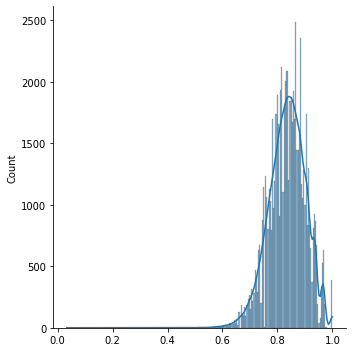

In [ ]:
# Plot OEDILF lexical diversity distribution
sns.displot(oedilf_lexical_diversity, kde=True)

# Load Two-stage LM Generated Limericks

In [ ]:
def generated_json_poems(fname):
  """Cleans up poems in the parsed jsons format into a list of strings and calculates lexical diversity"""
  f = open(fname)
  poems_json = json.load(f)
  
  poems = {}
  for k, p in poems_json.items():
    poems[k] = p.split('\n')  #convert back to list of line strings

  return poems_json, poems

In [ ]:
# Read in free form poems and parse them into separate limericks
free_form_fpath = os.path.join(DATA_DIR, '04_21_free_form_spell_checked_12832.json')
free_form_poems_json, free_form_poems = generated_json_poems(free_form_fpath)

In [ ]:
# Calculate lexical diversity for free form poems
free_form_lexical_diversity = calculate_lexical_diversities(free_form_poems.values())

In [ ]:
# Print out lexical diversity statistics for free form poems
lexical_diversity_stats(list(free_form_poems.values()), free_form_lexical_diversity)

Number of poems: 12832
 Lexical Diversity:
  Mean: 77.0%
  Max: 100.0%
  Min: 16.0%
DescribeResult(nobs=12832, minmax=(0.15841584158415842, 1.0), mean=0.7742928692331247, variance=0.006301550600854192, skewness=-0.6661800132922039, kurtosis=2.489193671136264)

Lexical Diversity: 100.0%
 I'm not using computers to make
but these gadgets? the world makes me quake
if they use this device
as that gadget, is nice
it's an error from every mistake

Lexical Diversity: 16.0%
 some of us are sure that it's true
many months have been long overdue
but, sadly of late
we're of late now, I'm late ? are you? we are late as well, too
<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


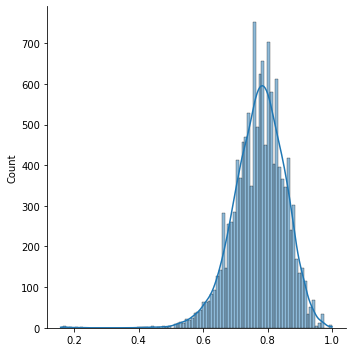

In [ ]:
# Plot distribution of free form lexical diversity
sns.displot(free_form_lexical_diversity, kde=True)

In [ ]:
# Filter out bassed on lexical diversity threshold (using mean and std of OEDILF)
threshold = 0.835 - 2*np.sqrt(0.004468)  # threshold based on mean-2*std of oedilf dataset

In [ ]:
# Filter out poems that fall under lexical diversity threshold
filtered_free_form_poems = {}
for i, k in enumerate(free_form_poems):
  if free_form_lexical_diversity[i] > threshold:
    filtered_free_form_poems[k] = {
        'poem': free_form_poems[k],
        'lexical_diversity': free_form_lexical_diversity[i]
        }

In [ ]:
# Print results for filtered poems
print(f'Total Poems: {len(free_form_poems)}')
print(f'Kept Poems: {len(filtered_free_form_poems)}')
print(f'Removed Poems: {len(free_form_poems)-len(filtered_free_form_poems)}')

Total Poems: 12832
Kept Poems: 10702
Removed Poems: 2130


In [ ]:
# Export filtered generated poems
output_fpath = os.path.join(DATA_DIR, '04_21_free_form_spell_checked_12832_ld_10702.json')
with open(output_fpath, 'w') as fp:
    json.dump(filtered_free_form_poems, fp)